In [326]:
import cv2
import numpy as np
import os
from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

The OS module in Python provides a way of using operating system dependent functionality.
Python method listdir() returns a list containing the names of the entries in the directory given by path.
os.chdir() method in Python used to change the current working directory to specified path.

In [310]:
print(os.getcwd()) 

C:\Users\tetal\AI\DividedDataSet


In [309]:
# Folder which contains all the images 
# from which video is to be generated 
path = "C:\\Users\\tetal\\AI\\DividedDataSet"
os.chdir(path)

In [45]:
mean_height = 0
mean_width = 0

num_of_images = len(os.listdir('.')) 
print(num_of_images) 

201


In [46]:
image_folder = 'C:\\Users\\tetal\\AI\\DividedDataSet\\Training\\Train024' # make sure to use your folder 
#video_name = 'mygeneratedvideo2.mp4

images = [img for img in os.listdir(path) 
if img.endswith(".tif") or
    img.endswith(".jpeg") or
    img.endswith("png")] 
#print(images)

In [40]:
for file in os.listdir('.'): 
    im = Image.open(os.path.join(path, file)) 
    width, height = im.size 
    mean_width += width 
    mean_height += height 
    # im.show() # uncomment this for displaying the image 

# Finding the mean height and width of all images. 
# This is required because the video frame needs 
# to be set with same width and height. Otherwise 
# images not equal to that width height will not get 
# embedded into the video 
mean_width = int(mean_width / num_of_images) 
mean_height = int(mean_height / num_of_images) 

# print(mean_height) 
# print(mean_width) 

# Resizing of the images to give 
# them same width and height 
for file in os.listdir('.'): 
    if file.endswith(".tif") or file.endswith(".jpeg") or file.endswith("png"): 
        # opening image using PIL Image 
        im = Image.open(os.path.join(path, file)) 

        # im.size includes the height and width of image 
        width, height = im.size 
        print(width, height) 

        # resizing 
        imResize = im.resize((238, 158), Image.ANTIALIAS) 
        imResize.save( file, "JPEG",quality = 95) # setting quality 
        # printing each resized image name 
        print(im.filename.split('\\')[-1], " is resized") 


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\tetal\\AI\\DividedDataSet\\Testing'

In [8]:
# Video Generating function 
def generate_video(images,outvid=None, fps=10, size=None,
               is_color=True, format="XVID"): 
	#image_folder = 'C:\\Users\\tetal\\AI\\Test001' # make sure to use your folder 
	video_name = 'mygeneratedvideo1.mp4'
	#os.chdir("C:\\Users\\tetal\\AI\\Test001") 
	
	#images = [img for img in os.listdir(image_folder) 
			#if img.endswith(".tif") or
				#img.endswith(".jpeg") or
				#img.endswith("png")] 
	
	# Array images should only consider 
	# the image files ignoring others if any 
	#print(images) 

	frame = cv2.imread(os.path.join(image_folder, images[0])) 

	# setting the frame width, height width 
	# the width, height of first image 
	height, width, layers = frame.shape 
	fourcc = VideoWriter_fourcc(*format)
	video = VideoWriter(video_name, fourcc, float(fps), (238, 158), is_color)

	# Appending the images to the video one by one 
	for image in images: 
		video.write(cv2.imread(os.path.join(image_folder, image))) 
	
	# Deallocating memories taken for window creation 
	cv2.destroyAllWindows() 
    
	video.release() # releasing the video generated 



In [9]:
# Calling the generate_video function 
generate_video(images) 

# Generating x,y feature vectors(mag, direction)
    Storing all the values from videos to one big array.

In [27]:
#Big arraycontains magnitude of all the videos in training set
mag_Bigarray_train = []
mag_Bigarray_test = []


# Sparse Optical Flow

In [322]:
cap = cv2.VideoCapture('mygeneratedvideo1.mp4')
print("satya")
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 25,
                       qualityLevel = 0.2,
                       minDistance = 4,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

count=0
index = 0;
ret,frame = cap.read()
while(ret):
   
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    #print(err)
    # Select good points
    good_new = p1[st==1]
    #print(good_new)
    good_old = p0[st==1]
    #print(good_old)
    
    
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        
        
        a,b = new.ravel()
        #print(a,b)
        c,d = old.ravel()
        #print(c,d)

        #print(c-a,d-b)
        if((a>c) & (b>d)):
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
    #print(p0)
    ret,frame = cap.read()
    
cv2.destroyAllWindows()
cap.release()

satya


# Dense Optical Flow

In [307]:
cap = cv2.VideoCapture("mygeneratedvideo68.mp4")
ret, frame1 = cap.read() #returns a bool (True/False). If frame is read correctly, it will be True. So you can check end of the video by checking this return value.
#print(frame1.shape)
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1) # Return a array of zeros of same type and shape as given array
hsv[...,1] = 255
count=0
index = 0;
ret, frame2 = cap.read()
mag_fullarray = []
#print(mag_fullarray)
while(ret):
   
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY) #For BGR \rightarrow Gray conversion we use the flags cv2.COLOR_BGR2GRAY

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    #prvs = next;
    pixel_array = np.array(flow)
    #print(pixel_array[0].shape)
    #print ("flow",flow)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    #print("magnitude",mag)
    #print(mag.shape)
    flattened_image = mag.flatten() # flatten the whole array as one input instead of 439 inputs
    mag_fullarray.append(flattened_image)
    
    #flattened_image = mag.flatten() # flatten the whole array as one input instead of 439 inputs
    
    #mag_array = np.array(mag)
    #print(mag_array.shape)
    #print("mag",mag.shape)
    #plt.hist(mag_array,bins=3)
    #plt.show()
    #print(len((mag_array)))
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    #print(hsv)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    #if count==10:
        #count=0
        
       # print ("flow",flow)
        
    cv2.imshow('frame2',rgb)
    count=count+1
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):    
        prvs = next
    ret, frame2 = cap.read()
    index = index+1
    #print(index)


mag_array = np.array(mag_fullarray)
#print("magfullarray",mag_fullarray[0])
flatten_video = mag_array.flatten() # flatten the whole array as one input instead of 439 inputs
print(flatten_video.shape)
flatten_video.reshape((199,37604))
#print(flatten_video.shape[1])
#mag_Bigarray_train = np.array(flatten_video)
#mag_Bigarray_train += flatten_video
mag_Bigarray_test.append(flatten_video)
#print("mag_Bigarray_train",mag_Bigarray_train[45])
cap.release()
cv2.destroyAllWindows()

(7483196,)


In [308]:
print(len(mag_Bigarray_test))
print((mag_Bigarray_test[0].shape))

20
(7483196,)


In [224]:
print(type(mag_Bigarray_test[0]))
print((mag_fullarray[5]))

<class 'numpy.ndarray'>
[0.02112589 0.01366441 0.01793827 ... 0.01037669 0.00979749 0.00808257]


In [314]:
from numpy import save
from numpy import load
#save('training_data1.npy',mag_Bigarray_train) ##Saving numpy array
#save('testing_data2.npy',mag_Bigarray_test) ##Saving numpy array

train_data = load('training_data1.npy',allow_pickle=True)
test_data = load('testing_data1.npy',allow_pickle=True)

In [316]:
print((train_data.shape))
labels_X = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#labels = [1,0,1]
#print(labels[47])
labels_Y = [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0]
print(test_data.shape)
X_train = train_data
Y_train = labels_X
X_test  = test_data
Y_test = labels_Y
print(type(X_train))
print(type(X_test))
print(type(Y_train))

(48, 7483196)
(20, 7483196)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>


In [319]:
model = SVC(kernel='rbf', gamma="auto")
#svclassifier = SVC(kernel='sigmoid')
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

In [325]:
cm = confusion_matrix(Y_test, predictions)
print(cm)

[[2 8]
 [4 6]]


In [330]:
cr = classification_report(Y_test, predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.33      0.20      0.25        10
           1       0.43      0.60      0.50        10

    accuracy                           0.40        20
   macro avg       0.38      0.40      0.38        20
weighted avg       0.38      0.40      0.38        20



In [5]:
# The video feed is read in as a VideoCapture object
cap = cv2.VideoCapture("mygeneratedvideo2.mp4")
# ret = a boolean return value from getting the frame, first_frame = the first frame in the entire video sequence
ret, first_frame = cap.read()
# Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
# Creates an image filled with zero intensities with the same dimensions as the frame
mask = np.zeros_like(first_frame)
# Sets image saturation to maximum
mask[..., 1] = 255
# ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
ret, frame = cap.read()
while(cap.isOpened()):
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    #ret, frame = cap.read()
    # Opens a new window and displays the input frame
    #cv2.imshow("input", frame)
    # Converts each frame to grayscale - we previously only converted the first frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Calculates dense optical flow by Farneback method
    # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Sets image hue according to the optical flow direction
    mask[..., 0] = angle * 180 / np.pi / 2
    # Sets image value according to the optical flow magnitude (normalized)
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    # Converts HSV to RGB (BGR) color representation
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    # Opens a new window and displays the output frame
    cv2.imshow("dense optical flow", rgb)
    # Updates previous frame
    prev_gray = gray
    # Frames are read by intervals of 1 millisecond. The programs breaks out of the while loop when the user presses the 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# The following frees up resources and closes all windows
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [16]:
print(len(mag_fullarray[50]))

158


<class 'numpy.ndarray'>


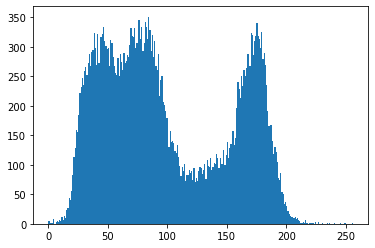

In [17]:
im = Image.open("001.tif")
#im.show()
imarray = np.array(im)
print(type(imarray))
plt.hist(imarray.ravel(),256,[0,256]); plt.show()

In [ ]:
length = len(mag_fullarray)
print("length",length)
for i in range (length):
    print(i)
    mag_array = mag_fullarray[i] 
    img = images[i+1]
    #im1array = cv2.imread(img)
    im = Image.open(img)
    imarray = np.array(im)
    image_array = np.asfarray(imarray).flatten().reshape((158,238))
    plt.subplot(2,2,1)
    plt.imshow(image_array)
    plt.title("Image")
    
    plt.subplot(2,2,2)
    plt.hist(mag_array,bins=22)
    plt.title("Histogram")
    
    plt.savefig('C:/Users/tetal/AI/Test001/New/00%s.png' %(i+1))
    #plt.show()
    #plt.imshow(image_array)

length 199
0
1


C:\Users\tetal\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\tetal\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\tetal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-d28eab09612f>", line 19, in <module>
    plt.savefig('C:/Users/tetal/AI/Test001/New/00%s.png' %(i+1))
  File "C:\Users\tetal\Anaconda3\lib\site-packages\matplotlib\pyplot.py", line 723, in savefig
    fig.canvas.draw_idle()   # need this if 'transparent=True' to reset colors
  File "C:\Users\tetal\Anaconda3\lib\site-packages\matplotlib\backend_bases.py", line 1907, in draw_idle
    self.draw(*args, **kwargs)
  File "C:\Users\tetal\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py", line 388, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\tetal\Anaconda3\lib\site-packages\matplotlib\artist.py", line 38, in draw_wrapper
    return draw(artist, renderer, *args, **kwargs)
  File "C:\Users\tetal\Anaconda3\lib\site-packages\matplotlib\figure.py"

KeyboardInterrupt: 

In [ ]:
min = 0
max = 0
length = len(mag_fullarray)
print("length",length)
for i in range (length):
print(i)

In [16]:
print(mag_array.size)
print(mag_array[0][237])

37604
0.6069918


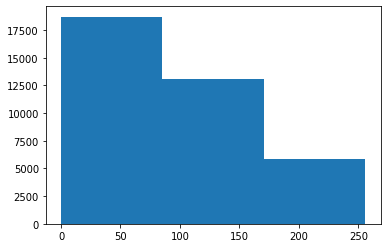

In [22]:

img = cv2.imread('001.tif',0)
plt.hist(img.ravel(),3,[0,256]); plt.show()

In [ ]:
print("hello!")